In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/temp'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import glob
import cv2
import torch.nn as nn 
import torch
import copy
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
batch_size = 4
train_path = "/kaggle/input/places2-mit-dataset/train_256_places365standard/data_256"
test_path = "/kaggle/input/places2-mit-dataset/test_256/test_256"
print("done")

done


In [4]:
file_names = glob.glob(os.path.join(test_path, "*.jpg"), recursive=True)
print(len(file_names))
print(file_names[:10])

328500
['/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00200871.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00155685.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00206486.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00234258.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00117801.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00200887.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00084891.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00012392.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00115332.jpg', '/kaggle/input/places2-mit-dataset/test_256/test_256/Places365_test_00055218.jpg']


In [5]:
# custom function to recursively get files from subdirs
def get_subdirectory_paths(root_dir):
    subdirs = []
    subsubdirs = []
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            subdirs.append(item_path)
    for subdir in subdirs:
        # this ignores subdirectories that have more sub dirs inside eg a/airfield/inside
        # used to reduce size of dataset and simplify it
        for item in os.listdir(subdir):
            item_path = os.path.join(subdir, item)
            if os.path.isdir(item_path):
                subsubdirs.append(item_path)
    return subsubdirs
dir_list = get_subdirectory_paths(train_path)
file_names = []
for dir in dir_list:
    files_in_dir = glob.glob(os.path.join(dir, "*.jpg"), recursive=True)
    # if directory is not empty, add its file in the total array
    if len(files_in_dir):
        file_names += files_in_dir
print(len(file_names))

1434892


# Data Preprocessing

In [6]:
class Placesdataset(Dataset):
    def __init__(self, dir_path, image_dim=(256,256),n_channels=3, mask_iterations = 5, dir=True, file_list=[]):
        if dir==True:
            # if the directory structure is simple we can pass the whole dir
            self.file_names = glob.glob(dir_path + '/*.jpg')
        else:
            # else we have to manually input the file paths
            self.file_names = file_list
        self.img_dim = image_dim
        self.to_tensor = transforms.ToTensor()
        self.channels = n_channels
        self.iterations = mask_iterations
        self.resize = transforms.Resize(image_dim)

    def __getitem__(self, idx):
        # gets image from file_path
        image = Image.open(self.file_names[idx]).convert("RGB")
        Y_output = self.resize(image)
        # creates and applies the mask 
        X_input, X_mask = self.create_mask(Y_output)
        # converts to tensor
        X_input = self.to_tensor(X_input)
        X_mask = self.to_tensor(X_mask)
        Y_output = self.to_tensor(Y_output)
        return X_input, X_mask, Y_output

        

    def __len__(self):
        return len(self.file_names)
    
    def line_generator(self, image):
        # uses openCV to autogenerate random lines and streaks
        # range found through trial and error
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            pt2 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            thickness =np.random.randint(10, 15)
            
            cv2.line(image, pt1=pt1, pt2=pt2, color=(1,1,1), thickness=thickness)

    def circle_generator(self, image):
        # uses openCV to autogenerate random circles 
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            radius =np.random.randint(5, 25)

            cv2.circle(image,pt1,radius,(1,1,1), -1)

    def create_mask(self, image):
        mask = np.full((self.img_dim[0], self.img_dim[1], self.channels), 255, dtype=np.uint8)
        self.line_generator(mask)
        self.circle_generator(mask)
        # uses bitwise and to apply mask to the image
        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

In [7]:
# due to resource constraints, I have decided to use 6,00,000 images from the dataset. 
Training_Data = Placesdataset(test_path, dir=False, file_list=file_names[:600_000])

Training_Loader = torch.utils.data.DataLoader(Training_Data, batch_size, shuffle=True)
print(len(Training_Loader))

Train_Iter = iter(Training_Loader)

150000


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
Masked Image


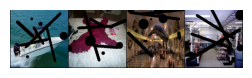

Masking Pattern


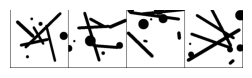

Original Image


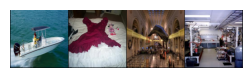

In [8]:
X_in, X_mask, Y_out = Train_Iter._next_data()
print(X_in.shape, X_mask.shape, Y_out.shape)

def imshow_masked(img):
  # converts tensor to image for display using matplotlib
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

![alt text](Places-2-network-architecture.png)

# Network

In [9]:
class Partial_Conv(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size=(3,3),stride=1, bias=True, groups=1,dilation=1, bn=True):
        super().__init__()
        self.bn = bn
        # padding is automatically calculated 
        padding = (kernel_size[0]//2, kernel_size[1]//2)
        self.input_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups,bias)
        self.mask_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups, False)

        self.window_size = kernel_size[0]*kernel_size[1]
        nn.init.constant_(self.mask_conv.weight, 1.0)
        nn.init.kaiming_normal_(self.input_conv.weight, a = 0, mode='fan_in')

        if self.bn:
            self.bath_normalization = nn.BatchNorm2d(output_filters)
        for param in self.mask_conv.parameters():
            param.requires_grad = False
    
    def forward(self, input, mask):
        output = self.input_conv(input * mask)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)
        # updates the mask so that it shrinks in size
        mask_ratio = self.window_size / (output_mask + 1e-8)
        output_mask = torch.clamp(output_mask, 0, 1)
        mask_ratio = mask_ratio * output_mask
        output = output * mask_ratio


        return output, output_mask

In [10]:
class EncodingLayer(nn.Module):
    # the encoding layer has a convolutional layer followed by RELU activation 
    def __init__(self, in_filters, out_filters, kernel=3, stride=1, bias=False, bn=True):
        super().__init__()
        
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.activation = nn.ReLU()
        self.conv = Partial_Conv(self.in_filters, self.out_filters,(kernel,kernel),stride, bias = bias, bn=bn)

    def forward(self, input, input_mask):
        output, output_mask = self.conv(input, input_mask)
        output = self.activation(output)
        return output, output_mask

In [11]:
class DecodingLayer(nn.Module):
    # the decoding layer upscales the image and concatanates the skip links from encoding layer
    def __init__(self, in_filters, out_filters, bn=True, activation=True, bias=False):
        super().__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        # these upsampling transfroms are used in smaller models
        # here I changed it to interpolation for smoother outputs
        self.up_image = nn.Upsample(scale_factor=(2,2))
        self.up_mask = nn.Upsample(scale_factor=(2,2))
        self.activate = activation
        self.conv = Partial_Conv(self.in_filters, self.out_filters, bias=bias,bn=bn)
        self.act = nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, input_image, input_mask, shared_image, shared_mask):
        # upscales the input, and combines the skip link from encoding layer along the channel axis
        upscaled_image = F.interpolate(input_image, scale_factor=2)
        upscaled_mask = F.interpolate(input_mask, scale_factor=2)
        combined_image = torch.cat([upscaled_image, shared_image], dim=1)
        combined_mask = torch.cat([upscaled_mask, shared_mask], dim=1)
        output_image, output_mask = self.conv(combined_image, combined_mask)
        if self.activate:
            output_image = self.act(output_image)
        return output_image, output_mask

In [12]:
class PartialConvUNet(nn.Module):
    def __init__(self, input_size = 256, layers = 7):
        if 2**(layers + 1) != input_size:
            raise AssertionError
        super().__init__()
        # see above network architecture for reference
        self.layers = layers 
        self.encoder_1 = EncodingLayer(3, 64, 7, 2, bn=False)
        self.encoder_2 = EncodingLayer(64, 128, 5, 2)
        self.encoder_3 = EncodingLayer(128, 256, 3, 2)
        self.encoder_4 = EncodingLayer(256, 512, 3, 2)

        for i in range(5, layers + 1):
            name = f"encoder_{i}"
            setattr(self, name, EncodingLayer(512, 512, 3, 2))

        for i in range(5, layers + 1):
            name = f"decoder_{i}"
            setattr(self, name, DecodingLayer(512+512, 512))

        self.decoder_4 = DecodingLayer(512 + 256, 256)
        self.decoder_3 = DecodingLayer(256 + 128, 128)
        self.decoder_2 = DecodingLayer(128 + 64, 64)
        self.decoder_1 = DecodingLayer(64 + 3, 3, bn=False, activation=False, bias=True)

    def forward(self, input_x, mask):
        # using dicts and setattr, getattr functions to loop through encoding and decoding layers and attach them
        encoder_dict = {}
        mask_dict = {}
        # h_0 represents first input
        key_prev = "h_0"
        encoder_dict[key_prev], mask_dict[key_prev] = input_x, mask

        for i in range(1, self.layers + 1):
            # encoding loop 
            encoder_key = f'encoder_{i}'
            key = f"h_{i}"
            encoder_dict[key], mask_dict[key] = getattr(self, encoder_key)(encoder_dict[key_prev], mask_dict[key_prev])
            key_prev = key
        
        out_key = f"h_{self.layers}"
        out_data, out_mask = encoder_dict[out_key], mask_dict[out_key]

        for i in range(self.layers, 0, -1):
            # decoding loop (runs in reverse)
            encoder_key = f"h_{i-1}"
            decoder_key = f"decoder_{i}"
            out_data, out_mask = getattr(self, decoder_key)(out_data, out_mask, encoder_dict[encoder_key], mask_dict[encoder_key])
        return out_data

# Loss Function

In [13]:
class LossFunction(nn.Module):
    # following the research paper definition of loss functions
    def __init__(self, extractor):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.extractor = extractor
    
    def gram_matrix(self, feat):
        # https://en.wikipedia.org/wiki/Gram_matrix
        (b, ch, h, w) = feat.size()
        feat = feat.view(b, ch, h * w)
        feat_t = feat.transpose(1,2)
        gram = torch.bmm(feat, feat_t) / (ch * h * w)
        return gram

    def total_var_loss(self, image):
        # shift one pixel and get difference (for both x and y)
        loss = torch.mean(torch.abs(image[:,:,:,:-1] - image[:,:,:,1:])) + \
            torch.mean(torch.abs(image[:,:,:-1,:] - image[:,:,1:,:]))
        return loss
    

    def forward(self, input, mask, output, original):
        loss_dict = {}
        output_comp = mask * input + (1 - mask) * output
        loss_dict['hole'] = self.l1((1 - mask) * output, (1 - mask) * original)
        loss_dict['valid'] = self.l1(mask * output, mask * original)

        feat_output_comp = self.extractor(output_comp)
        feat_output = self.extractor(output)
        feat_original = self.extractor(original)

        loss_dict['prc'] = 0.0
        # uses vgg16 features to generate perceptual loss for each RGB channel
        for i in range(3):
            loss_dict['prc'] += self.l1(feat_output[i], feat_original[i])
            loss_dict['prc'] += self.l1(feat_output_comp[i], feat_original[i])

        loss_dict['style'] = 0.0
        # uses gram matrix of vgg16 features to generate style loss for each RGB channel
        for i in range(3):
            loss_dict['style'] += self.l1(self.gram_matrix(feat_output[i]),
                                          self.gram_matrix(feat_original[i]))
            loss_dict['style'] += self.l1(self.gram_matrix(feat_output_comp[i]),
                                          self.gram_matrix(feat_original[i]))
            
        loss_dict['tv'] = self.total_var_loss(output_comp)
        # returns dict of all the individual losses
        return loss_dict

# VGG Feature Extraction 

In [14]:
class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = torchvision.models.vgg16(weights='DEFAULT')
        # seperates the vgg16 features into 3 slices for feature extraction
        self.enc_1 = nn.Sequential(*vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        for i in range(3):
            # freezes the params
            for param in getattr(self, f'enc_{i+1}').parameters():
                param.requires_grad = False

    def forward(self, image):
        # creates an array of results for each slice
        # first index is the input image which is removed in the output of forward
        results = [image]
        for i in range(3):
            func = getattr(self, f'enc_{i+1}')
            # applies the correspoinding encoder slice on the last index of the results array
            results.append(func(results[-1]))

        return results[1:]

# Training Loop 

In [15]:
model = PartialConvUNet().to(device)
extractor = VGG16FeatureExtractor().to(device)
loss_fn = LossFunction(extractor).to(device)
opt = torch.optim.Adam(model.parameters())
# loss weights as defined in the research paper
LAMBDA_DICT = {
    'valid': 1.0, 'hole': 6.0, 'tv': 0.1, 'prc': 0.05, 'style': 120.0}

loss_arr = []
index_arr = []
max_epochs = 1
min_loss = 1000
n_iters = np.ceil(len(Training_Loader))
for epoch in range(max_epochs):
    model.train()
    for i, (x_input, x_mask, y_output) in enumerate(Training_Loader):
        x_input, x_mask, y_output = x_input.to(device), x_mask.to(device), y_output.to(device)
        opt.zero_grad()

        output_img = model(x_input, x_mask)
        loss_dict = loss_fn(x_input, x_mask, output_img, y_output)
        loss = 0.0
        for key, coef in LAMBDA_DICT.items():
            value = coef * loss_dict[key]
            loss += value
            if (i + 1) % 100 == 0:
                string = f'loss_{key}'
                print(f'{string:<10}',":", f"{value.item():.5f}",f"Batch: {i + 1}")
                print(f'loss_total : {loss.item():.6f} Batch: {i+1}')

        loss.backward()
        opt.step()
        # saves the model with min loss using deep copy
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print(f'Min loss: {min_loss:.5f}')

        if (i + 1) % 100 == 0:
            index_arr.append(i)
            loss_arr.append(loss.item())

        # if i == 400:
        #     break



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s]


Min loss: 3.58807
Min loss: 3.34304
Min loss: 3.32495
Min loss: 3.14876
Min loss: 3.10279
Min loss: 2.88964
Min loss: 2.86504
Min loss: 2.84660
Min loss: 2.80704
Min loss: 2.44620
Min loss: 2.06837
Min loss: 1.71955
Min loss: 1.56593
loss_valid : 0.07556 Batch: 100
loss_total : 0.075561 Batch: 100
loss_hole  : 0.24135 Batch: 100
loss_total : 0.316908 Batch: 100
loss_tv    : 0.01133 Batch: 100
loss_total : 0.328237 Batch: 100
loss_prc   : 0.18432 Batch: 100
loss_total : 0.512561 Batch: 100
loss_style : 2.72606 Batch: 100
loss_total : 3.238625 Batch: 100
Min loss: 1.54885
Min loss: 1.47589
Min loss: 1.45461
Min loss: 1.34201
loss_valid : 0.06956 Batch: 200
loss_total : 0.069558 Batch: 200
loss_hole  : 0.31407 Batch: 200
loss_total : 0.383629 Batch: 200
loss_tv    : 0.00782 Batch: 200
loss_total : 0.391445 Batch: 200
loss_prc   : 0.16193 Batch: 200
loss_total : 0.553371 Batch: 200
loss_style : 1.69581 Batch: 200
loss_total : 2.249178 Batch: 200
Min loss: 1.33723
Min loss: 1.29402
Min loss

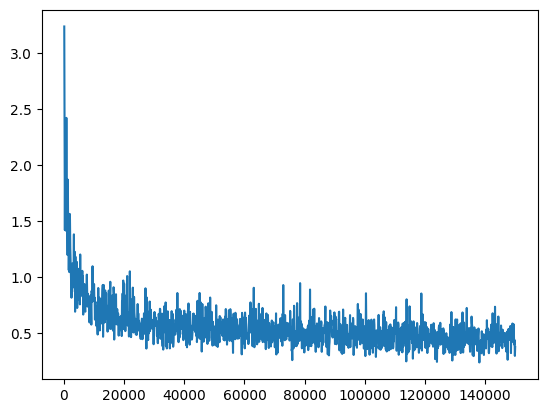

In [16]:
plt.plot(index_arr, loss_arr)
plt.show()


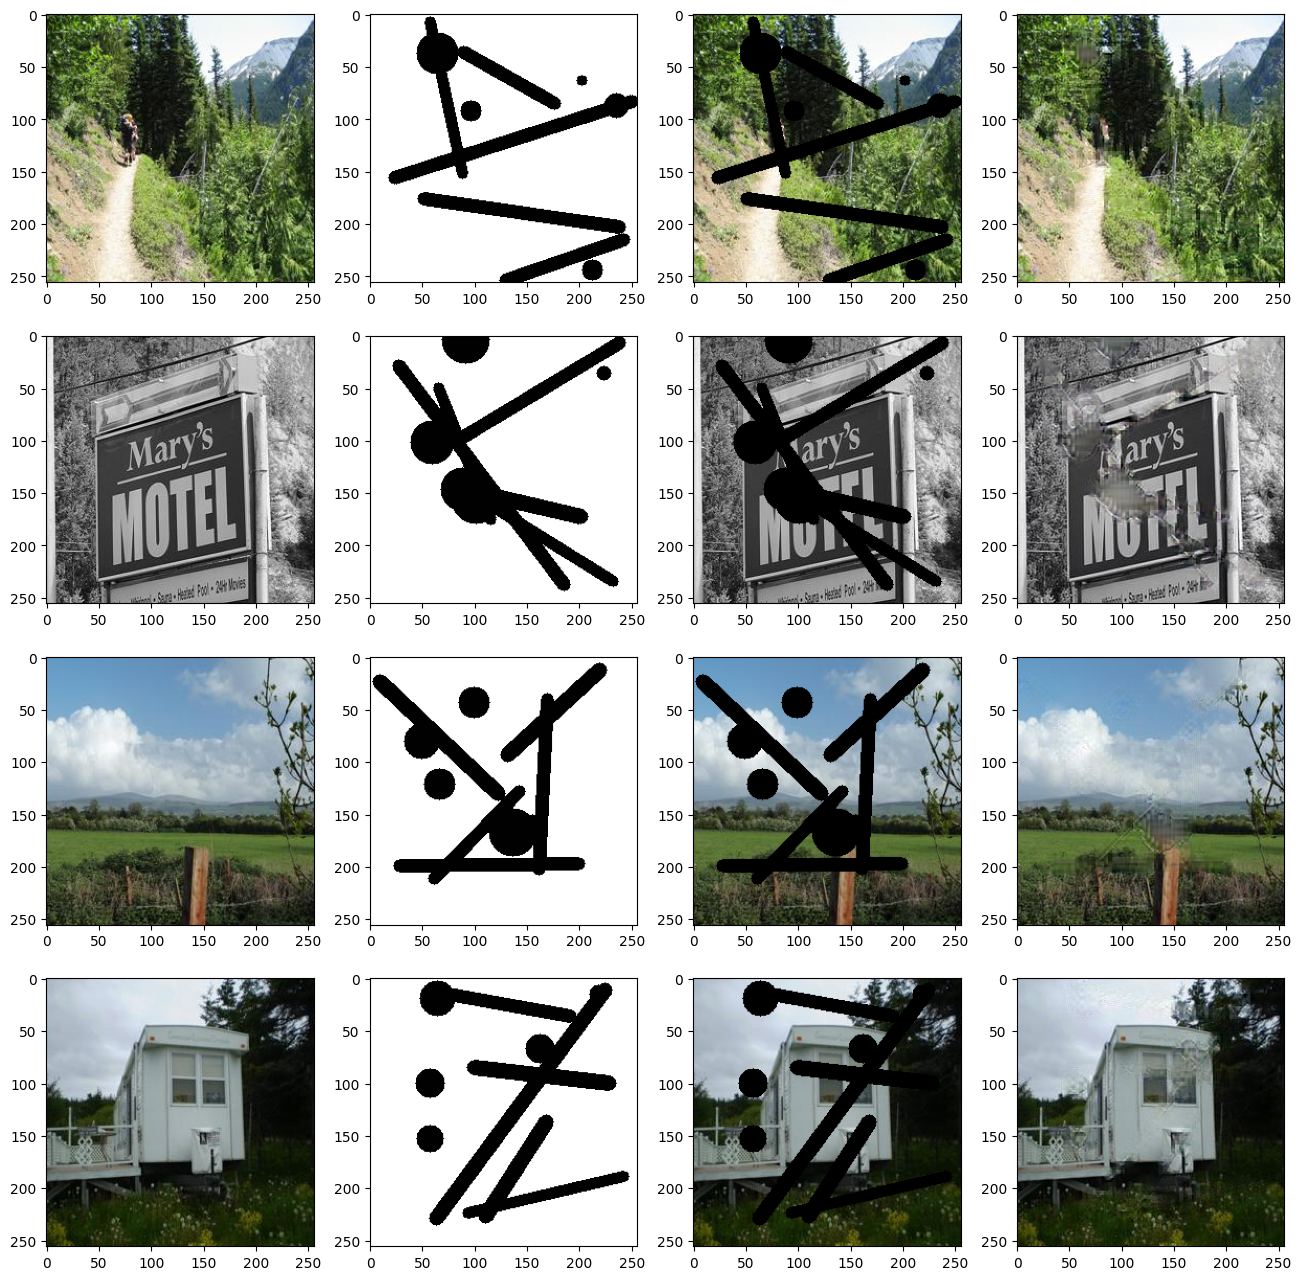

In [17]:
model.load_state_dict(best_model)

sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
sample_inputs, sample_masks = sample_inputs.to(device), sample_masks.to(device)
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

In [18]:
saving = True
if saving:
    torch.save(model.state_dict(), "ImageInpainting600k.pt")
import os
print("running")
# Path to the working directory
working_dir = '/kaggle/working'
# to clear previous outputs for next iteration
deleting = False
# Loop through all files in the directory
if deleting == True:
    for file_name in os.listdir(working_dir):
        file_path = os.path.join(working_dir, file_name)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file

        except Exception as e:
            print(f"Failed to delete {file_name}. Reason: {e}")
    for file_name in os.listdir("/kaggle/working/output_images"):
        file_path = os.path.join("/kaggle/working/output_images", file_name)

        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file

        except Exception as e:
            print(f"Failed to delete {file_name}. Reason: {e}")
print("done")

running
done


In [19]:
evaluating = True
import os
import matplotlib.pyplot as plt
import numpy as np

# Ensure an output directory exists
os.makedirs("output_images", exist_ok=True)

model = PartialConvUNet().to(device)
model.load_state_dict(torch.load("ImageInpainting600k.pt", weights_only=True))

# Iterate through batches to process 200 images
for batch_idx in range(50):  # 50 batches x 4 images = 200 images
    # Unfortunately I first got outputs on the training data
    # working on a seperate notebook to get outputs on the testing directory
    sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
    sample_inputs, sample_masks = sample_inputs.to(device), sample_masks.to(device)
    
    with torch.no_grad():
        sample_preds = model(sample_inputs, sample_masks)
    
    sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
    
    for i in range(4):
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
        
        # Ground truth
        axs[0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
        axs[0].set_title("Ground Truth")
        axs[0].axis('off')

        # Mask
        axs[1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
        axs[1].set_title("Mask")
        axs[1].axis('off')

        # Input
        axs[2].imshow(np.transpose(sample_inputs[i], (1, 2, 0)))
        axs[2].set_title("Input")
        axs[2].axis('off')

        # Prediction
        axs[3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
        axs[3].set_title("Prediction")
        axs[3].axis('off')
        
        # Save image to disk
        output_path = f"output_images/batch_{batch_idx}_image_{i}.png"
    
        plt.savefig(output_path)
        plt.close(fig)
    print(f"{batch_idx}, done")



0, done
1, done
2, done
3, done
4, done
5, done
6, done
7, done
8, done
9, done
10, done
11, done
12, done
13, done
14, done
15, done
16, done
17, done
18, done
19, done
20, done
21, done
22, done
23, done
24, done
25, done
26, done
27, done
28, done
29, done
30, done
31, done
32, done
33, done
34, done
35, done
36, done
37, done
38, done
39, done
40, done
41, done
42, done
43, done
44, done
45, done
46, done
47, done
48, done
49, done
